In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import math 
import scipy as sp



In [ ]:
def normalize(matrix):
    div=np.max(matrix)-np.min(matrix)
    if div ==0:
        div=1
    normalizedData = ((matrix-np.min(matrix))/div)*255
    return normalizedData

In [ ]:
#Load images

snrImg = []
snrReconstruct = []

rootNoisy = "gr5/Noisy"
noisyImgs = glob.glob(f"{rootNoisy}/*.bmp") + glob.glob(f"{rootNoisy}/*.jpg") 

rootOriginal = "gr5/Original"
originalImgs = glob.glob(f"{rootOriginal}/*.bmp") + glob.glob(f"{rootOriginal}/*.jpg")

originalImgs.sort()
noisyImgs.sort()

In [ ]:
#presa un immagine definisco i tipi di rumore

img = cv2.imread(originalImgs[1],0)
np.random.seed(42)

#Rumore gaussiano
noise = np.random.normal(size=img.shape)
imgNoisyGauss = img + noise
imgNoisyGauss = cv2.normalize(imgNoisyGauss, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

histOrig, bins = np.histogram(img.ravel(), bins=256, range=(0, 255))
histNoise, bins = np.histogram(imgNoisyGauss.ravel(), bins=256, range=(0, 255))

histNoiseOnlyGauss = histNoise - histOrig

#Rumore uniforme
low = 0
high = 255
noise = np.random.uniform(low, high, img.shape)
#noise = np.random.rand(*img.shape) * 255
imgNoisyUni = img + noise
imgNoisyUni = cv2.normalize(imgNoisyUni, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

histNoise, bins = np.histogram(imgNoisyUni.ravel(), bins=256, range=(0, 255))
histNoiseOnlyUnif = histNoise - histOrig

#Rumore sale e pepe
x,y = img.shape
noise = np.random.rand(x,y)*255
salt = noise > 240
pepper = noise < 15
imgNoisySandP = img.copy()
imgNoisySandP[salt] = 255
imgNoisySandP[pepper] = 0
imgNoisySandP = cv2.normalize(imgNoisySandP, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

histNoise, bins = np.histogram(imgNoisySandP.ravel(), bins=256, range=(0, 255))

histNoiseOnlySandP = histNoise - histOrig

#matplot delle immagini con istogrammi
fig, axes = plt.subplots(4,2,figsize=(7,7))
fig.tight_layout()
axes[0][0].imshow(img, cmap="gray")
axes[0][0].set_title(f"Immagine originale")

axes[0][1].hist(img.ravel(),256,[0,256])
axes[0][1].set_title(f"Istogramma immagine originale")

axes[1][0].imshow(imgNoisyGauss, cmap="gray")
axes[1][0].set_title(f"Immagine rumorosa gauss")

axes[1][1].hist(histNoiseOnlyGauss,256,[0,256])
axes[1][1].set_title(f"Istogramma rumore gauss")

axes[2][0].imshow(imgNoisyUni, cmap="gray")
axes[2][0].set_title(f"Immagine rumorosa uniforme ")

axes[2][1].hist(histNoiseOnlyUnif,256,[0,256])
axes[2][1].set_title(f"Istogramma rumore uniforme ")

axes[3][0].imshow(imgNoisySandP, cmap="gray")
axes[3][0].set_title(f"Immagine rumorosa sale e pepe ")

axes[3][1].hist(histNoiseOnlySandP,256,[0,256])
axes[3][1].set_title(f"Istogramma rumore sale e pepe ")

plt.show()

Creation of a Gaussian Filter

The Gaussian filter is a type of filter that applies a Gaussian distribution to an image through convolution.

To create a Gaussian filter, we first apply the Gaussian formula including the required values of sigma and the size of our mask. This is implemented through the functions "gauss," which returns the Gaussian function given sigma and x dimensions, and "create mask," which returns the mask with the required values given the mask dimensions and sigma. At this point, the "gaussianFilter" function, which takes the image, mask size, and sigma as input, applies the filter through a 2D convolution.

In [ ]:
#Gaussian filter
def gauss(sigma,x):
    ''' 
    Input: sigma: Value of sigma for Gauss function, x: Centered value to apply Gauss

    Output: Gauss function applied to sigma and x
    '''
    gauss = 1/(math.sqrt(2*math.pi)*sigma)*math.e**(-(x**2/(2*sigma**2)))
    return gauss

def createMask(maskSize, sigma):
    ''' 
    Input: maskSize: Dimension for the mask, sigma: Value of sigma for Gauss function

    Output: Mask 
    '''
    mask = np.zeros([maskSize + 1, maskSize +1], dtype = float)
    centre = int(maskSize / 2) + 1
    for i in range(1, maskSize +1):
        for j in range(1, maskSize +1):
            dist = np.sqrt(np.power(abs(i-centre),2)+np.power(abs(j-centre),2))
            mask[i][j] = gauss(sigma, dist)
    return mask


def gaussianFilter(img = cv2.imread(noisyImgs[1],0), maskSize = 3, sigma = 15):
    mask = createMask(maskSize, sigma)
    conv=cv2.filter2D(img, ddepth=-1, kernel=mask)
    #plt.figure()
    #plt.imshow(conv,cmap="gray")
    return conv



Creation of a Median Filter

The median filter is a filter that, by averaging the pixels in the surrounding area and the pixel under consideration, reduces impulsive noise or other irregular noise patterns.

The median filter is simpler to implement than the Gaussian filter, as it takes portions of the image of the kernel size and, after vectorizing the portion, calculates the median and puts it in the reconstructed image at the i-j-th position.

In [ ]:
def medianFilter(img =cv2.imread(noisyImgs[5],0) , maskSize = 3):
    m, n = np.shape(img)
    median = np.zeros_like(img)
    for i in range(1,m-1):
      for j in range (1,n-1):
         l = img[i:i + maskSize, j:j + maskSize].ravel()
         median[i,j] = np.mean(l)
    #plt.figure()
    #plt.imshow(median,cmap="gray")
    return median



In [38]:
def denoiseImage(X, WEp=0.3, exp=0.9):
  ''' 
  input: X np array for an image, iter int for number of iteration, WEp weight for data penalty

  output: Denoised imaged

  '''
  Y = np.copy(X)
  intesities = np.arange(260)
  mask = np.array([[0,1,0],[1,0,1],[0,1,0]])
  mask = mask * WEp

  energyMatrix = []

  for i in intesities:
    matrix = Y-i
    conv = cv2.filter2D(matrix, ddepth=-1, kernel=mask)
    tryIntensityEp = conv
    tryIntensityEp = np.power(tryIntensityEp,exp)
    tryIntensityEd = matrix**2
    sum = tryIntensityEp + tryIntensityEd
    energyMatrix.append(sum)
  
  energyMatrix = np.asarray(energyMatrix)
   

  #questo è ok perché prendiamo l'indice che ha come significato l'intensità di colore
  x,y,z = np.shape(energyMatrix)
  for i in range(y):
    for j in range(z):
      Y[i,j] = np.argmin(energyMatrix[:,i,j])
      #Possibile ottimizzazione: scrivere una funzione che prende la matrice energia e la divida per il numero di processori e poi faccia multiprocessing
  
  energyMatrix=[]
  #Da ottimizzare questa parte di post processing, magari usando un modulo
  
  return Y.astype(dtype=np.uint8)


In [39]:
reconstructedImgs = []
#for i in range(len(originalImgs)):
for i in range(1):

    print(f"image#:{i}                    ")
    imgOriginal = cv2.imread(originalImgs[i],0)
    imgNoisy = cv2.imread(noisyImgs[i],0)
    
    reconstructedImgs.append(denoiseImage(imgNoisy, exp = 0.1, WEp=0.25))

    #reconstructedImgs.append(denoiseImage(medianFilter(imgNoisy, maskSize=3),exp = 0.1, WEp=0.25))
'''
fig, axes = plt.subplots(3,1,figsize=(10,10))
fig.tight_layout()
axes[0].imshow(imgOriginal,cmap="gray")
axes[0].set_title('Original Image')
axes[1].imshow(imgNoisy,cmap="gray")
axes[1].set_title('Noisy Image')
axes[2].imshow(imgReconstructed, cmap="gray")
axes[2].set_title('Denoised Image')
plt.show()
'''

image#:0                    


'\nfig, axes = plt.subplots(3,1,figsize=(10,10))\nfig.tight_layout()\naxes[0].imshow(imgOriginal,cmap="gray")\naxes[0].set_title(\'Original Image\')\naxes[1].imshow(imgNoisy,cmap="gray")\naxes[1].set_title(\'Noisy Image\')\naxes[2].imshow(imgReconstructed, cmap="gray")\naxes[2].set_title(\'Denoised Image\')\nplt.show()\n'

In [ ]:
for i in range(len(reconstructedImgs)):
    cv2.imwrite(f"denoisedImages/DenoisedImage#{i}.jpeg",reconstructedImgs[i])


In [ ]:

def PSNR(x1, x2):
    mse = np.mean((x1 - x2) ** 2)
    if(mse == 0):  
        return 100
    max_pixel = 255.0
    psnr = 20 * math.log10(max_pixel / np.sqrt(mse))
    return psnr

for i in range(len(reconstructedImgs)):
    imgOriginal = cv2.imread(originalImgs[i],0)
    imgNoisy = cv2.imread(noisyImgs[i],0)
    PSNRDenoisedNoisy = PSNR(reconstructedImgs[i], imgNoisy)
    PSNROriginalyNoisy = PSNR(imgOriginal, imgNoisy)
    print(f"Image#:{i} \n    PSNR from denoised to noisy: {round(PSNRDenoisedNoisy,3)} dB \
          \n    PSNR from original to noisy: {round(PSNROriginalyNoisy,3)} dB")

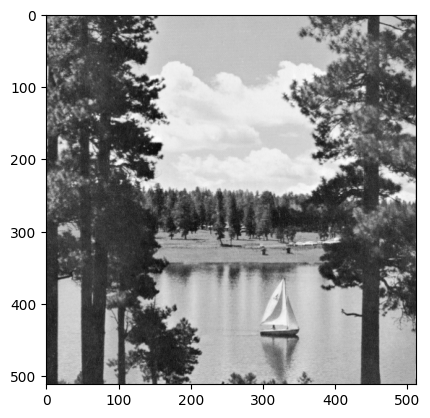

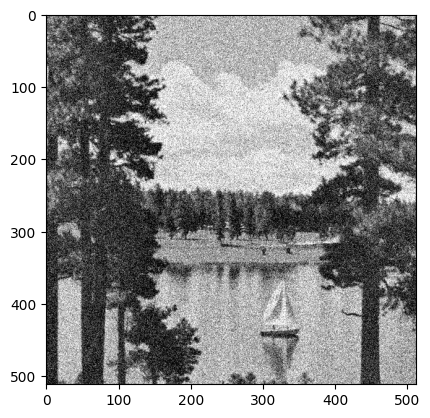

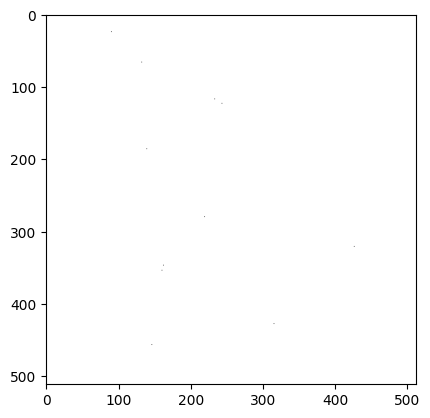

In [34]:

for i in range(len(reconstructedImgs)):
    imgOriginal = cv2.imread(originalImgs[i],0)
    imgNoisy = cv2.imread(noisyImgs[i],0)
    plt.imshow(imgOriginal,cmap="gray")
    plt.show()
    plt.imshow(imgNoisy,cmap="gray")
    plt.show()    
    plt.imshow(reconstructedImgs[i], cmap="gray")
    plt.show()    
